In [25]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import fsspec
import cftime
from dask import optimize
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
import scipy.signal as signal
from scipy.signal import detrend, cwt, morlet

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [3]:
df_area = df.query("variable_id == 'areacella' & source_id == 'CESM2' & experiment_id =='historical'")
ds_area = xr.open_zarr(fsspec.get_mapper(df_area.zstore.values[-1]), consolidated=True)
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])

In [8]:
# df_ta_ncar = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2' & variable_id == 'tas'  & institution_id == 'NCAR'")
df_EW_ncar_his = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'ua' & institution_id == 'NCAR' & experiment_id == 'historical'")

# get the path to a specific zarr store (the first one from the dataframe above)
zstore_his = df_EW_ncar_his.zstore.values[-1]
print(zstore_his)

# create a mutable-mapping-style interface to the store
mapper_his = fsspec.get_mapper(zstore_his)

# open it using xarray and zarr
ds_EW_his = xr.open_zarr(mapper_his, consolidated=True)
display(ds_EW_his)


# date_threshold = cftime.DatetimeNoLeap(1550, 1, 1)
# ds_tas_his_plt = ds_tas_his.where(ds_tas_his.time > date_threshold, drop=True)
# # weighted product
# tas_timeseries_his = (ds_tas_his_plt.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
# # convert to np array
# array_tas_ts = np.array(tas_timeseries_his)
# # plt.plot(array_tas_ts)
# # plt.show()
# year_tas_ts = np.mean(array_tas_ts.reshape(1980//12, 12), axis=1)
# # plt.plot(year_tas_ts)
# # plt.show()

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/ua/gn/v20190514/


<xarray.Dataset>
Dimensions:    (lat: 192, nbnd: 2, lon: 288, plev: 19, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    ua         (time, plev, lat, lon) float32 dask.array<chunksize=(60, 19, 192, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    variable_id:            ua
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/05f2f382-e465-4c2b-9a09-e5e9d4e45c19...
    version_id:             v20190514

## Selected latitude range from 30 to 60 North. All longitudes

In [ ]:
wind_u = ds_EW_his.sel(plev=20000)

lat_range = ds_EW_his.lat.sel(lat=slice(30, 60))
lon_range = ds_EW_his.lon.sel(lon=slice(0, 360))
# Here I am taking the mean
wind_timeseries = (wind_u.ua * ds_area.areacella).sel(lat=lat_range, lon=lon_range).mean(dim=["lat", "lon"])
wind_timeseries

<xarray.DataArray (time: 1980)>
dask.array<mean_agg-aggregate, shape=(1980,), dtype=float32, chunksize=(60,), chunktype=numpy.ndarray>
Coordinates:
    plev     float64 2e+04
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

### Don't re-run this cell if lat and lon range not changed

In [24]:
# wind_timeseries = wind_timeseries.chunk({'time': 1980})
# wind_timeseries = wind_timeseries.persist()
# wind_timeseries

wind_timeseries = wind_timeseries.squeeze()  # Removes the 'plev' axis if it's size 1
wind_timeseries = wind_timeseries.compute()  # Forces computation to memory
wind_np = wind_timeseries.values  # Fastest way to get NumPy array
wind_np

array([2.7107233e+11, 2.3991658e+11, 2.3502291e+11, ..., 2.2325461e+11,
       2.7069281e+11, 2.8080108e+11], dtype=float32)

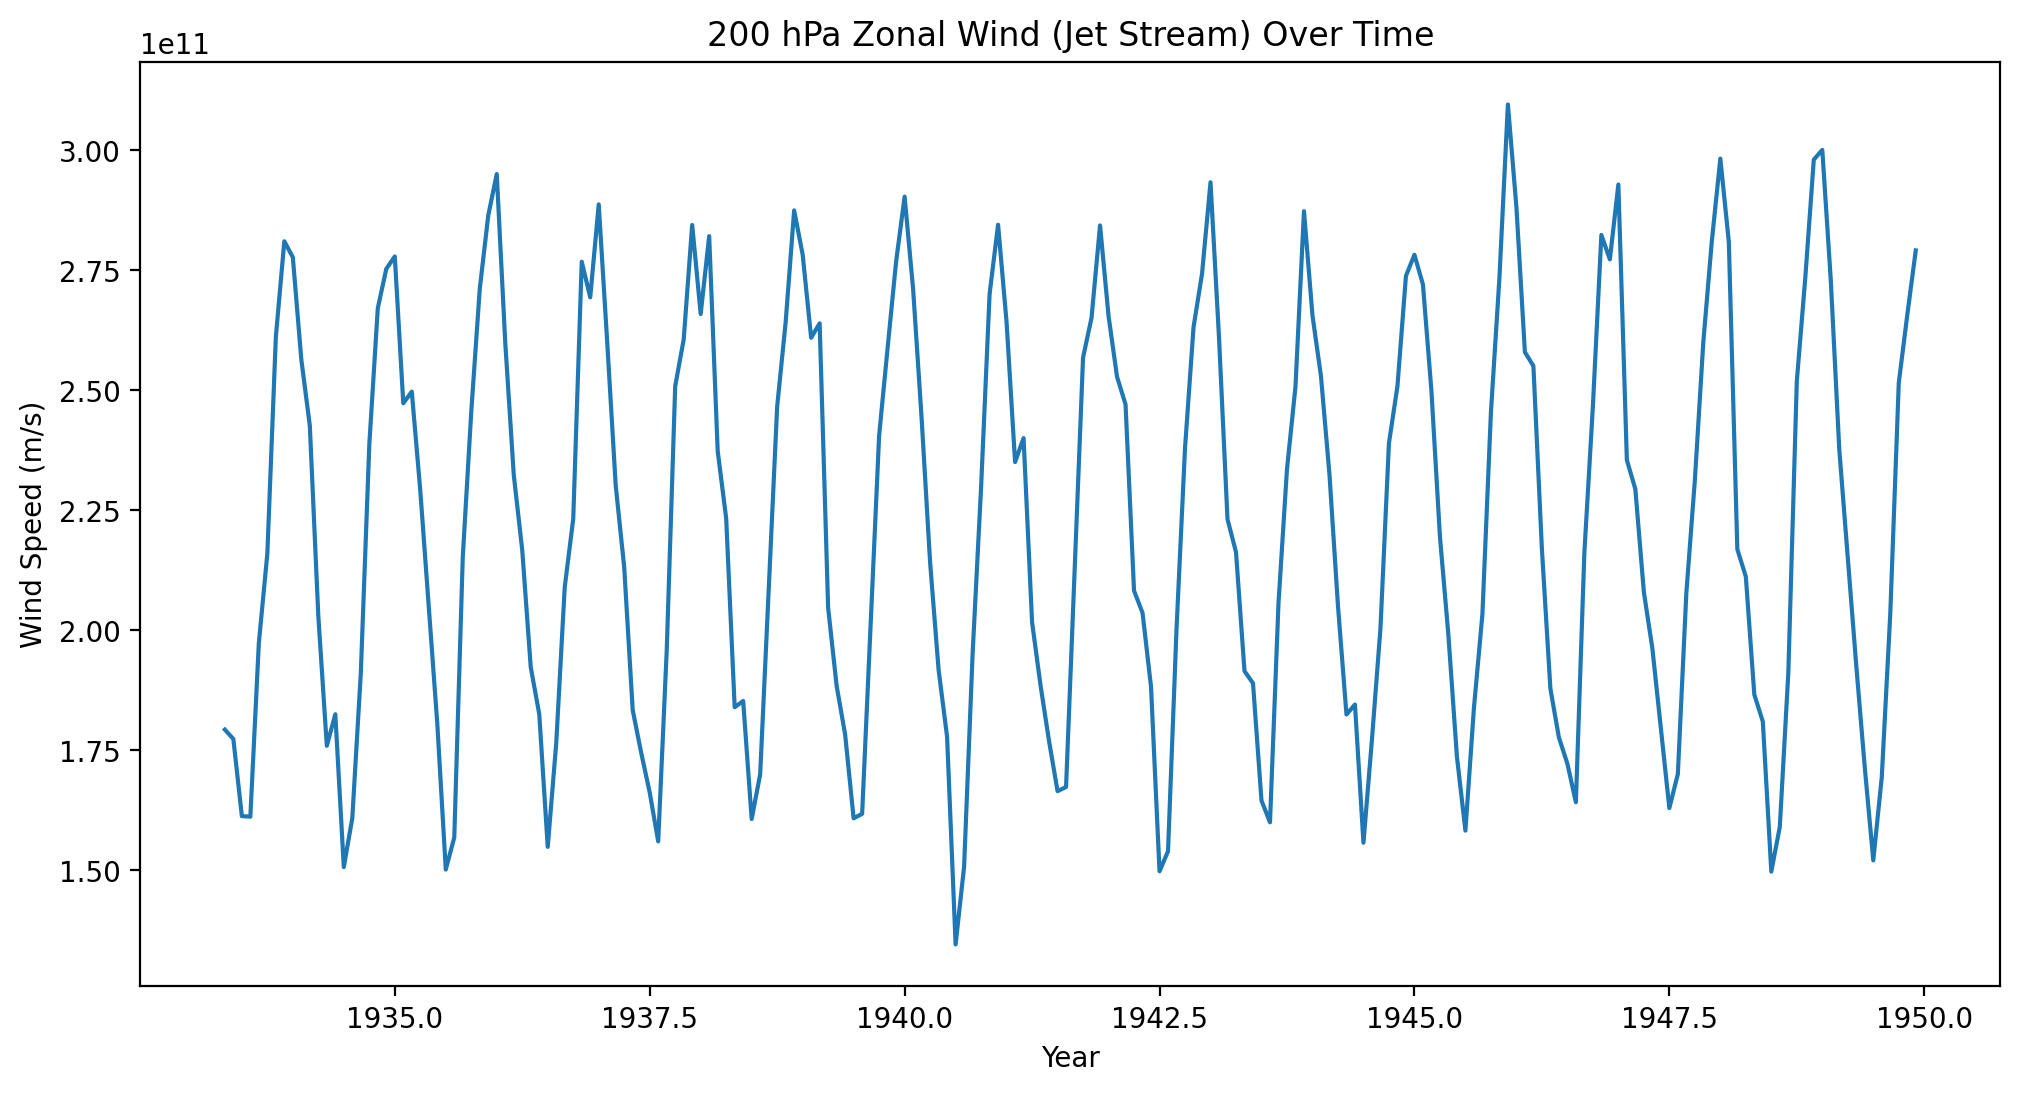

In [63]:
# months = np.array(wind_timeseries.time)
# months = pd.to_datetime(months).astype('datetime64[ns]')
time_left, time_right = 1000, 1200
plt.plot(time[time_left: time_right], wind_np[time_left: time_right])
plt.title("200 hPa Zonal Wind (Jet Stream) Over Time")
plt.xlabel("Year")
plt.ylabel("Wind Speed (m/s)")
plt.show()

In [57]:
time = np.arange(1850, 2015, 1/12)

# Extract wind data
wind_data = wind_timeseries.values

# Remove long-term trend and normalize data
wind_data = detrend(wind_data)
wind_data = (wind_data - np.mean(wind_data)) / np.std(wind_data)  # Normalize

In [45]:
# Define scales (equivalent to periods in years)
# scales = np.logspace(0.1, 2, num=100)
scales = np.logspace(0.1, 2, num=100).astype(int)  # Adjust scale range as needed

# Compute CWT using Morlet wavelet
wavelet_power = cwt(wind_data, morlet, scales)


In [47]:
# Approximate period (in years) for each scale
sampling_rate = 1  # Assuming annual data
periods = scales / sampling_rate  # Convert scales to equivalent periods

In [64]:
# Define wavelet scales (convert to integers)
scales = np.logspace(0.1, 2, num=100).astype(int)

# Compute Continuous Wavelet Transform (CWT)
wavelet_coeffs = cwt(wind_data, morlet, scales)

# Compute wavelet power (energy at each time-frequency point)
wavelet_power = np.abs(wavelet_coeffs) ** 2

# Select dominant frequency band (e.g., keeping only 5–15 year oscillations)
dominant_scales = (scales > 5) & (scales < 15)  # Select based on period range

# Apply inverse CWT using only dominant scales
filtered_wavelet = np.where(dominant_scales[:, None], wavelet_coeffs, 0)  # Zero out unwanted scales
reconstructed_signal = np.sum(filtered_wavelet, axis=0)  # Sum over scales

# Normalize the reconstructed signal
reconstructed_signal = (reconstructed_signal - np.mean(reconstructed_signal)) / np.std(reconstructed_signal)



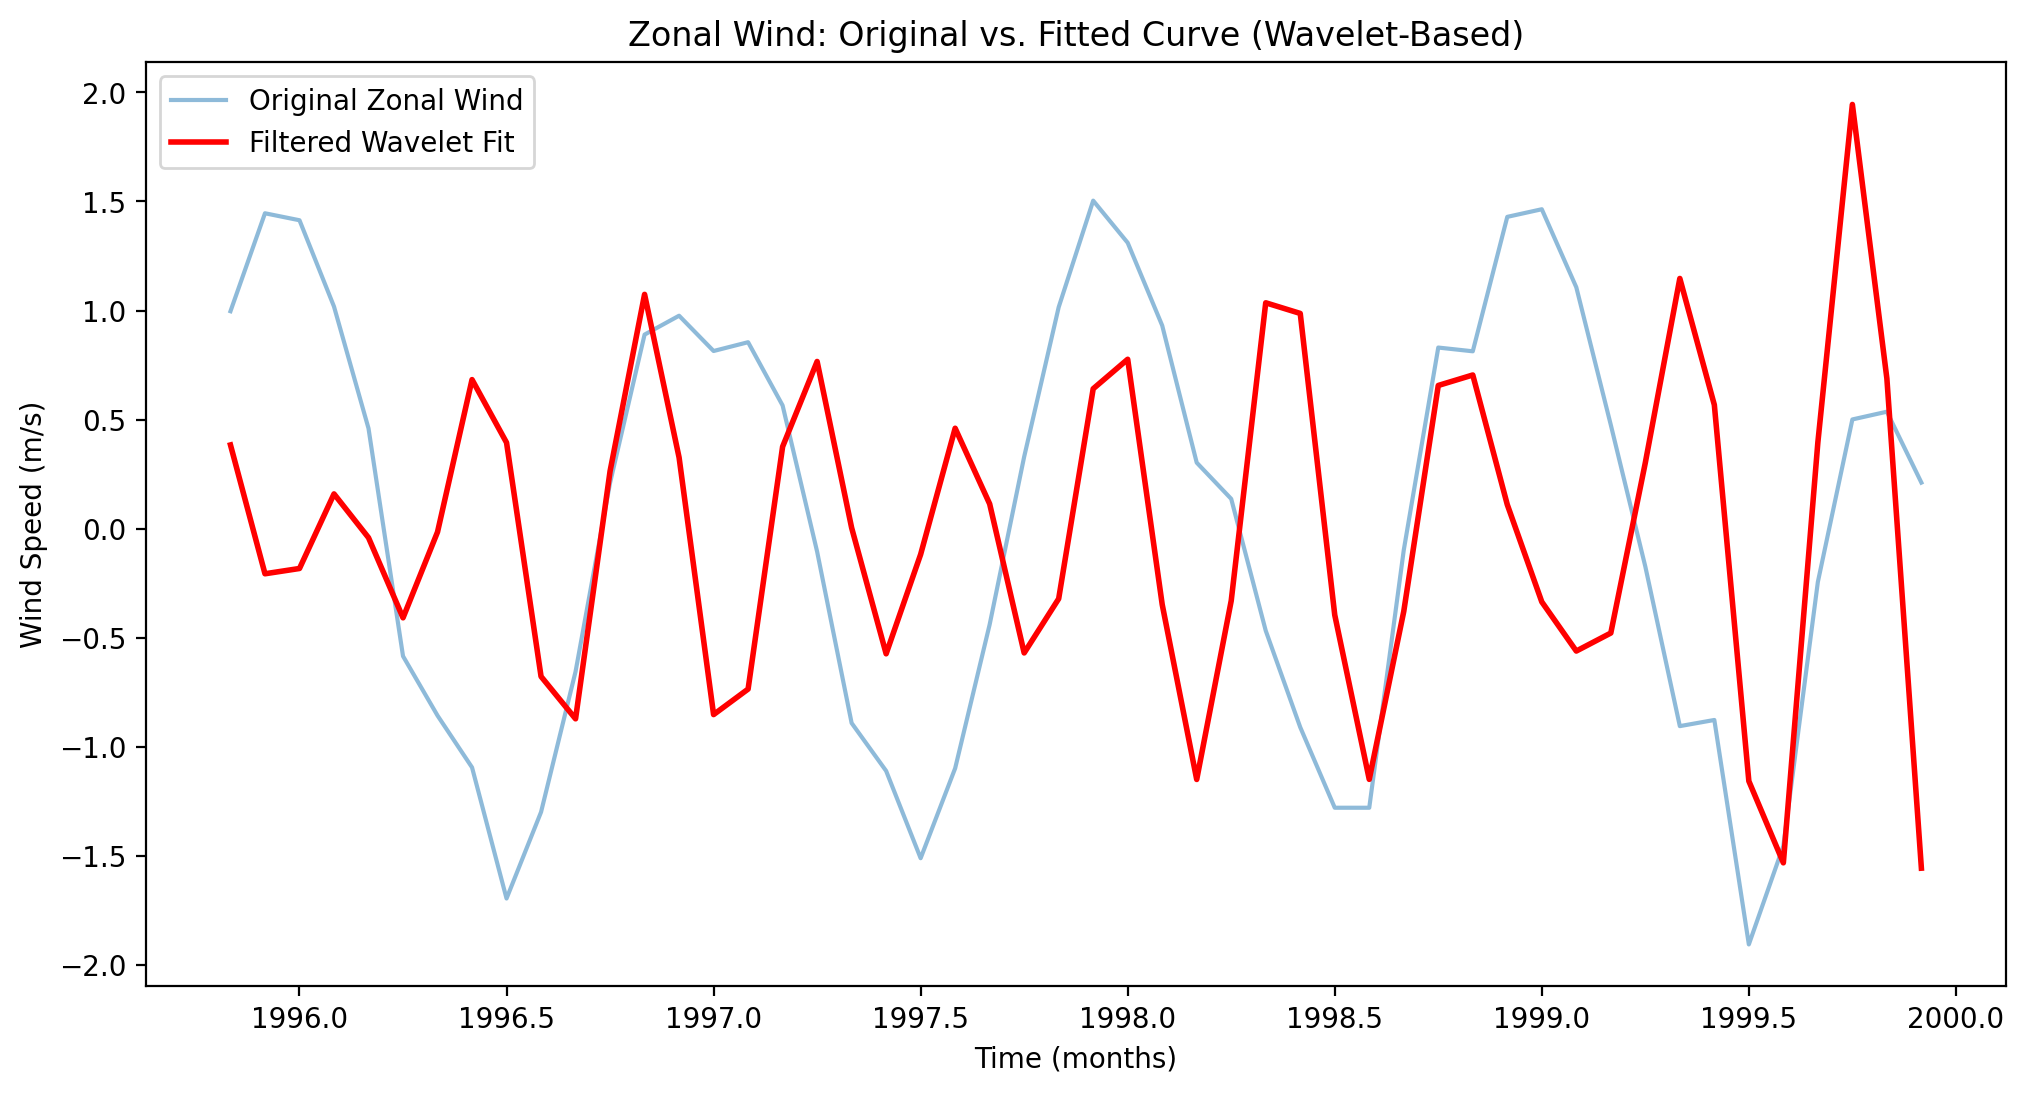

In [71]:
# Plot Original vs. Reconstructed Signal
plt.figure(figsize=(12, 6))
t_left, t_right = 1750, 1800
plt.plot(time[t_left:t_right], wind_data[t_left:t_right], label="Original Zonal Wind", alpha=0.5)
plt.plot(time[t_left:t_right], reconstructed_signal[t_left:t_right], label="Filtered Wavelet Fit", color="red", linewidth=2)
plt.xlabel("Time (months)")
plt.ylabel("Wind Speed (m/s)")
plt.title("Zonal Wind: Original vs. Fitted Curve (Wavelet-Based)")
plt.legend()
plt.show()

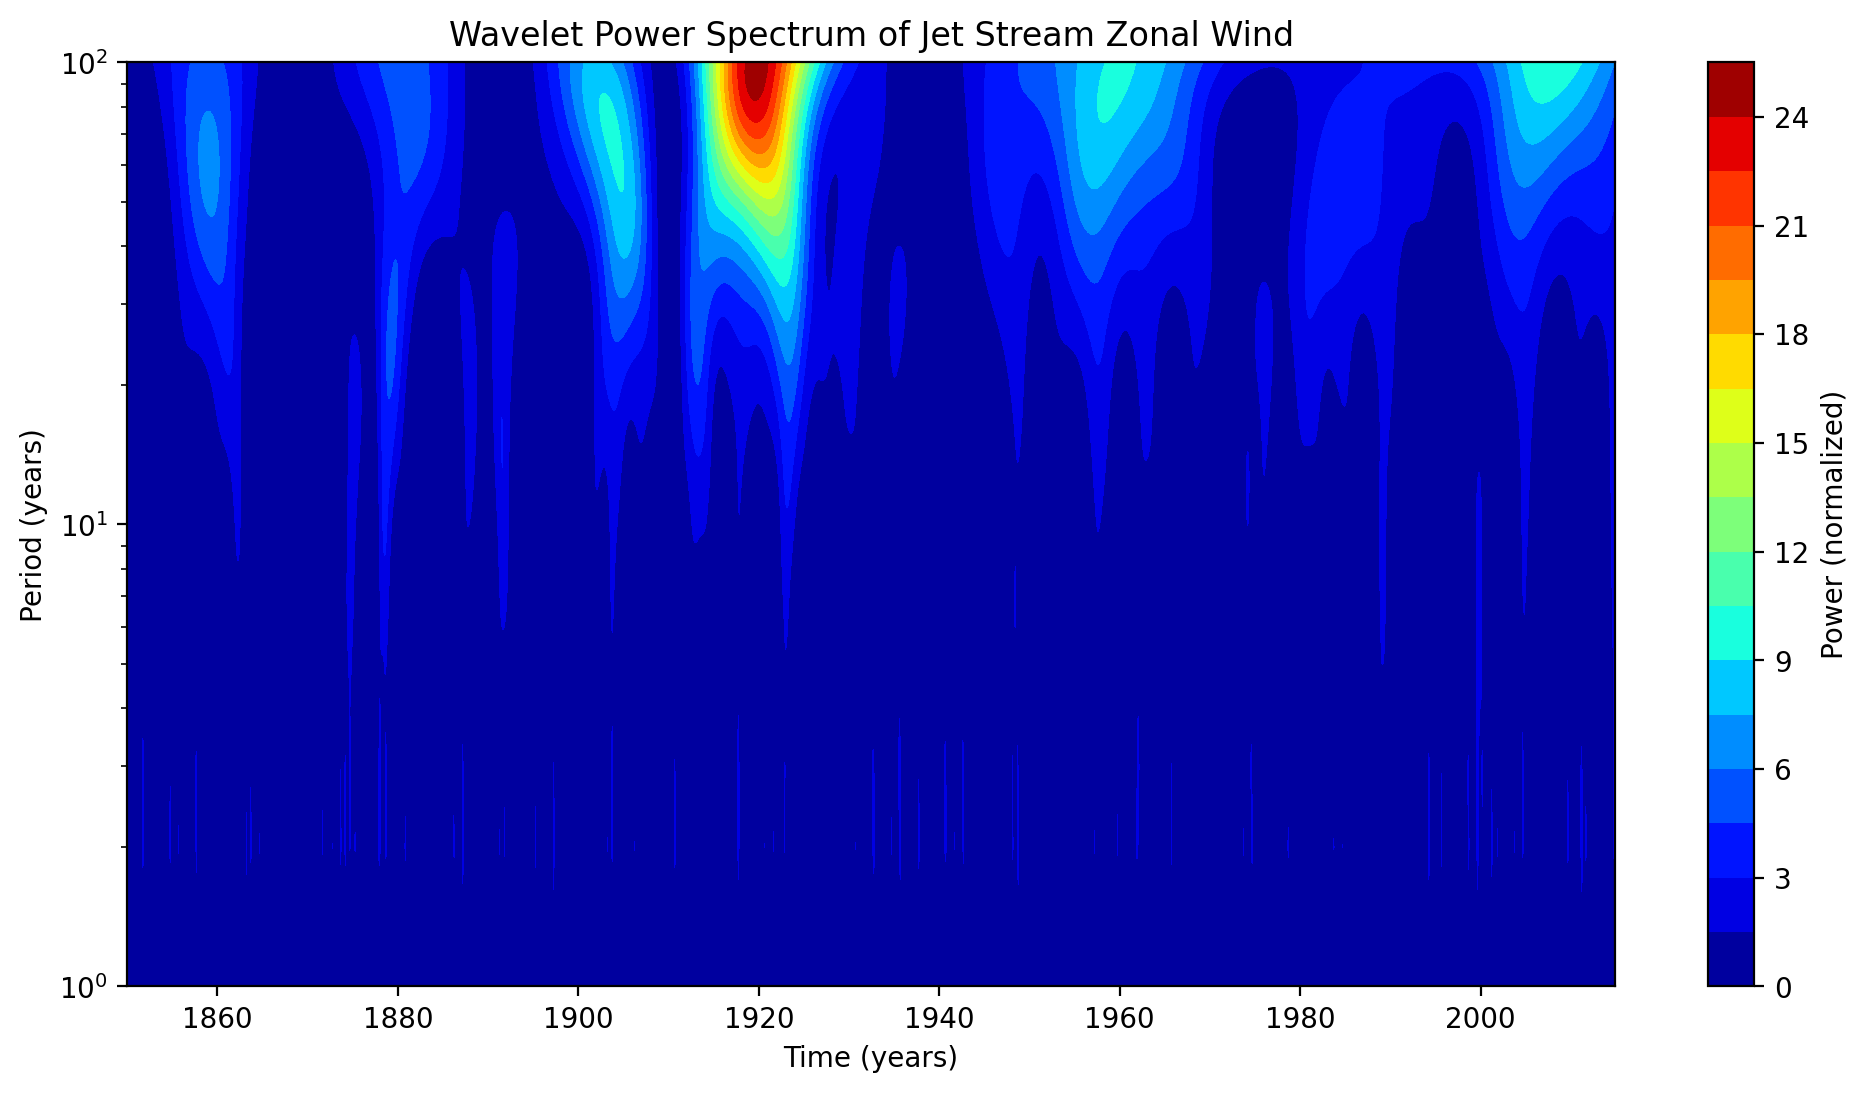

In [61]:
fig, ax = plt.subplots(figsize=(12, 6))

# Contour plot of wavelet power spectrum
plt.contourf(time, periods, np.abs(wavelet_power), levels=20, cmap="jet")

# Log scale for period axis
plt.yscale("log")
plt.xlabel("Time (years)")
plt.ylabel("Period (years)")
plt.title("Wavelet Power Spectrum of Jet Stream Zonal Wind")

# Add colorbar
cbar = plt.colorbar()
cbar.set_label("Power (normalized)")

plt.show()
